## Method 2b, Top ALS Rating: use existing users in filled utility matrix as proxies to new user
### Model hyperparameter tuning and evaluation

### Springboard Capstone 2 project: building a recommendation engine
### John Burt

The goal of my project is to develop a working board game recommender using a dataset of explicit game ratings from the boardgamegeek.com forum site. My idea was to ask a user to name some games that they like, and my recommender algorithm will use those games to predict other games the user might like. The first problem I encountered was that any user asking for a recommendation will be unknown to the system - i.e., they are "new users" and that presents a classic cold start issue: how do you give a recommendation if you don't know much about the user? Well, we do have the user's "liked games" to work with, but any model will need to somehow match that pattern of preferences to the preference patterns in the existing data.

### Model description
The second recommender model I developed is actually what I would call the "baseline" model: that is, it's based on the most common means of generating recommendations: using ALS based matrix factorization on the target user's ratings to fill in estimated ratings for all items, then selecting the highest rated to use as recommendations. The problem with this method for new users is that you need to "fold-in" the new user: add their ratings to the dataset and re-factorize the matrix. This is very CPU and memory intensive and not a viable production solution unless you can apply some tricks that I can't replicate here. 

In this version, I eliminate the expensive user fold-in and re-factorization step by selecting users in the existing data with similar game preferences to use as proxies for the new user. The proxy users' ratings are averaged and the top rated games from the averaged ratings are used as recommendations.

To select the proxy users for a given new user who has provided a list of "liked" games, I select the top rated games for each existing user and score each based on how many of their top games are in the new user's "liked" game list. The existing users with the highest overlap in top games become the new user's proxy users (number of proxy users is a hyperparameter).

### Evalution function
As with all models tested, I'm using a custom evaluation function to tune and assess the model:

- Dataset is the unfilled user x game ratings matrix, train/test split by user.
- For each test user:
    - From N*2 top rated games, randomly select N as "liked games" to use as model input (X values).
    - Remaining N top rated games assigned as holdouts to test for recommendations (y values).
    - User score = # holdout games recommended / N
    - The overall score is the mean user score for all test users.


### Purpose of this notebook:

Tune hyperparameters and evaluate the Top ALS rating proxy user model for various metrics.



## Load data

In [7]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

pd.options.display.max_rows = 100

srcdir = './data/'

# load the filled item-user utility matrix
df = pd.read_hdf(srcdir+'bgg_game_mx_unfilled.h5', 'mx')

print('original: #games X #users:', df.shape)


original: #games X #users: (12600, 69910)


## Reduce the data

In [8]:
numusers = 30000
numgames = 6000
gameidx = np.array(range(numgames))
np.random.shuffle(gameidx)
useridx = np.array(range(numusers))
np.random.shuffle(useridx)
df = df.iloc[gameidx, useridx]
print('reduced: #games X #users:', df.shape)


reduced: #games X #users: (6000, 30000)


## Split data into train/test sets

Split by user, so that all ratings by a given user are either in the train or test set.

In [9]:
from sklearn.model_selection import train_test_split

# transpose so users = rows
df_u = df.T

# change index name to userID
df_u.index.name = 'userID'

# make userID a column
df_u = df_u.reset_index()

# split into train and test sets
train, test = train_test_split(df_u, test_size=.1 )

# set train and test index to userID
train = train.set_index('userID')
test = test.set_index('userID')

print('train set:',train.shape, '  test set:',test.shape)


train set: (27000, 6000)   test set: (3000, 6000)


## Split test into X ('liked' games) and y (target)

- From N*2 top rated games, select N as "liked games" to use as model input (X values).
- Remaining N top rated games assigned as holdouts to test for recommendations (y values).


In [10]:
n_top = 20
n_liked = int(n_top/2)
n_recs = n_liked

# arrays to hold X and y game IDs
test_X = np.zeros([test.shape[0],n_liked])
test_y = np.zeros([test.shape[0],n_recs])
game_ids = test.columns.values

# for each user, select top n_top games and split them into X and y categories
for i in range(test.shape[0]):
    row = test.iloc[i,:].values # row=1 user's ratings (including nans)
    # get indices to descending sort of ratings (nans sorted to bottom)
    idx = np.argsort(-row)
    # top n_top highest rated game IDs
    top = game_ids[idx[:(n_top)]]
    # randomize order
    np.random.shuffle(top)
    # assign to X (liked games) and y(games to test for recced)
    test_X[i,:] = top[:n_liked]
    test_y[i,:] = top[n_liked:]

print(test_X.shape, test_y.shape)


(3000, 10) (3000, 10)


## Implement recommender as sklearn estimator object

In [35]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from numpy.random import shuffle

# import utility functions
import sys
sys.path.append('./')
import recsys_utilities
import importlib
importlib.reload(recsys_utilities)
from recsys_utilities import do_ALS_df

class Recommender_ALS_proxy_users(BaseEstimator, ClassifierMixin):
    """recommender engine as an estimator"""

    def __init__(self, 
                regularization=0.1, 
                n_factors=100,
                n_iterations=8,
                scale=True,
                weighted=True,
                bm25_K1=10,
                bm25_B=0.8,
                n_top_items=10,
                n_proxy_users=10,
                verbose=False
                ):
        """
        Called when initializing the model
        """
        # model parameters
        self.regularization = regularization
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.scale = scale
        self.weighted = weighted
        self.bm25_K1 = bm25_K1
        self.bm25_B = bm25_B
        
        self.n_top_items = n_top_items
        self.n_proxy_users = n_proxy_users
        
        self.verbose = verbose
        
        # internal data used for making recommendations
        self.user_factors = None
        self.item_factors = None
        self.item_IDs = None
        self.top_rated = None
        self.item_dict = None

    # ******************************************************************
    def set_params(self, **params):
        self.__dict__.update(params)

    # ******************************************************************
    def get_top_rated_cols(self, mx, n_top):
        top = np.zeros((mx.shape[0],n_top), dtype=np.int64)
        for i in range(mx.shape[0]):
            idx = np.argsort(-mx[i,:])
            top[i,:] = idx[:n_top]
        return top

    # ******************************************************************
    def fit(self, X, y=None):
        """ Train the recommender.
            This means, fill the item matrix with estimated ratings using ALS.
            You can also pass a filled matrix (has no empty cells / NaN values),
              and the fit function will skip the ALS step.
            X = pd DataFrame filled/unfilled utility matrix
        """
        # fill utility matrix using ALS if it contains NaNs
        self.user_factors, self.item_factors = do_ALS_df(
            X, ALS_method='implicit', return_utilmx=False,
            n_iterations=self.n_iterations, 
            regularization=self.regularization, 
            n_factors=self.n_factors, 
            verbose=self.verbose,
            scale=self.scale,
            weighted=self.weighted,
            bm25_K1=self.bm25_K1,
            bm25_B=self.bm25_B,
            use_native=True,
            use_cg=True,
            use_gpu=False,
            )   
        
        # create array of game IDs
        self.item_IDs = X.columns.values.astype(int)
        
        self.top_rated = self.get_top_rated_cols(X.values, self.n_top_items)

        # create gameID - column index mapping
        self.item_dict = {key: value for (key, value) in zip(self.item_IDs, range(len(self.item_IDs)))}

        return self
    
    # ******************************************************************
    def get_sorted_proxy_index(self, user_liked):
        liked_idx_set = set([self.item_dict[gameID] for gameID in user_liked])
        scores = [-len(liked_idx_set.intersection(row)) for row in self.top_rated]
        return np.argsort(scores)

    # ******************************************************************
    def ratings_from_factors(self, row_index):
        return (np.dot(self.user_factors[row_index,:], self.item_factors.T))
    
    # ******************************************************************
    def recommend_games_by_proxy(self, user_liked, num2rec=10): 
        
        # get indices to proxy users
        proxy_idx = self.get_sorted_proxy_index(user_liked)

        # average/median ratings for all games among proxies
        ratings = np.mean(self.ratings_from_factors(proxy_idx), axis=0)

        # desc sort ratings
        game_idx = np.argsort(-ratings)

        # select num2rec top rated game IDs        
        return self.item_IDs[game_idx[:num2rec]]
        
    # ******************************************************************
    def predict(self, X, y=None, num2rec=10):
        """predict == recommend board IDs = y
        X = array of user liked game IDs
        """

        # recommend game IDs for each row of liked games in X
        y = np.zeros([X.shape[0], num2rec])
        for i in range(X.shape[0]):
            y[i,:] = self.recommend_games_by_proxy(X[i,:], num2rec=num2rec)

        return y

    # ******************************************************************
    def score(self, y_true, y_pred):
        """mean percent of y_true game IDs in y_pred
        Both arrays are shape [num_users, num_gameIDs]"""
        
        n_recced = y_pred.shape[1]
        
        result = np.zeros([y_true.shape[0]])
        for i,(x,y) in enumerate(zip(y_true, y_pred)):
            result[i] = len(set(x).intersection(y))/n_recced        
        
        return np.mean(result)
    

## Test and time the model

In [36]:
from time import time

# model defaults
defaults = {
    'n_factors': 50,
    'weighted': False,
    'bm25_K1': 4,
    'bm25_B': 0.5,
    'n_iterations': 10,
    'verbose': True,
    'scale': False,
    'regularization': 0.3,
    'n_top_items': 20,
    'n_proxy_users': 100,
    }
rec = Recommender_ALS_proxy_users(**defaults)

start = time()
rec.fit(train)
print('fit time:',time()-start)


fitting ALS model



fit time: 18.42934536933899


In [37]:
n_samps = 100

start = time()
y_pred = rec.predict(test_X[:n_samps], num2rec=n_recs)
print('predict time:',time()-start)
start = time()
score = rec.score(test_y[:n_samps], y_pred[:n_samps])
print('score time:',time()-start)
print('score = %1.6f'%(score))    

predict time: 78.48794555664062
score time: 0.001001119613647461
score = 0.130000


## Hyperparameter optimization using Baysian methods

I'm using the hyperparameter tuning package [hyperopt](https://github.com/hyperopt/hyperopt).


In [266]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import f1_score, roc_auc_score
from time import time
from hyperopt import tpe, hp, fmin, Trials
from time import time
from hyperopt import space_eval

# model defaults
defaults = {
    'n_factors': 5,
    'weighted': False,
    'bm25_K1': 4,
    'bm25_B': 0.5,
    'n_iterations': 10,
    'verbose': False,
    'scale': True,
    'regularization': 0.3,
    'n_top_items': 10,
    'n_proxy_users': 10,
    'select_method': 'average',
    }
 
# hyperopt parameter space
# param space if B25 weighting isn't used
paramspace = {
    'n_factors': 1+hp.randint('n_factors', 100),
    'n_top_items': 1+hp.randint('n_top_items', 50),
    'n_proxy_users': 5+hp.randint('n_proxy_users', 200),
#     'regularization': hp.uniform('regularization', 0.01, 1.0),
    }

# # param space if I use BM25 weighting
# paramspace = {
#     'n_factors': 10+hp.randint('n_factors', 200),
#     'BM25 weighted': hp.choice('BM25 weighted', [
#         {
#             'weighted': True,
#             'bm25_K1': 1+hp.randint('bm25_K1', 10),
#             'bm25_B': hp.uniform('bm25_B', 0.1, 1.0),
#         },
#         {
#             'weighted': False,
#         }
#     ]) }
                       
# hyperopt objective function
def objective(params):
    rec = Recommender_ALS_proxy_users(**defaults)
    rec.set_params(**params)
    rec.fit(train)
    idx = np.array(range(test_X.shape[0]))
    shuffle(idx)
    # for performance reasons I only test a subset of the test users
    n_samps = 100
    y_pred = rec.predict(test_X[idx[:n_samps]], num2rec=n_recs)
    score = rec.score(test_y[idx[:n_samps]], y_pred)
    return 1-score

# hyperparameter tuning:
# The Trials object will store details of each iteration
trials = Trials()
    
# Run the hyperparameter search using the tpe algorithm
t0 = time()
print('  tune model')
best = fmin(fn=objective, space=paramspace, algo=tpe.suggest, max_evals=50, trials=trials)
print('    done in %0.3fs,'%(time() - t0))

# Get the values of the optimal parameters
best_params = space_eval(paramspace, best)
print('\n  Best parameters:',best_params)   

rec = Recommender_ALS_proxy_users(**defaults)
rec.set_params(**best_params)
rec.fit(train)
y_pred = rec.predict(test_X, num2rec=n_recs)
score = rec.score(test_y, y_pred)
print('score =', score) 
    

  tune model
100%|█████████████████████████████████████████████████████████████| 50/50 [1:26:26<00:00, 103.72s/it, best loss: 0.831]
    done in 5186.212s,

  Best parameters: {'n_factors': 51, 'n_proxy_users': 99, 'n_top_items': 22}
score = 0.13553333333333334


## Plotting the optimization results

avg best error: 0.831


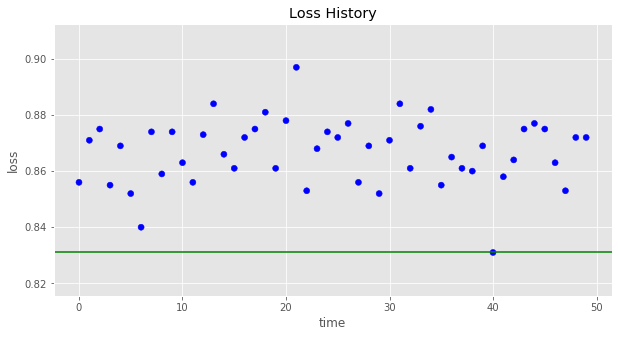

Showing Histogram of 50 jobs


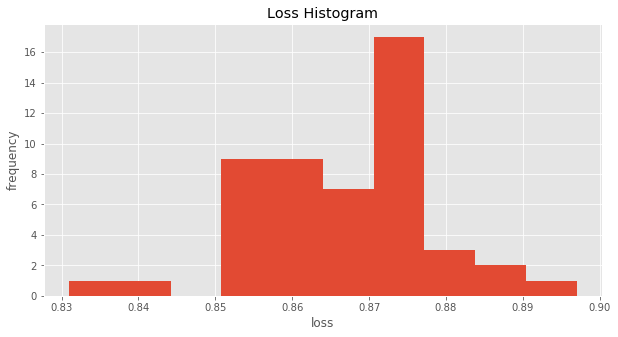

finite loss range 0.831 0.897 -0.16900000000000004


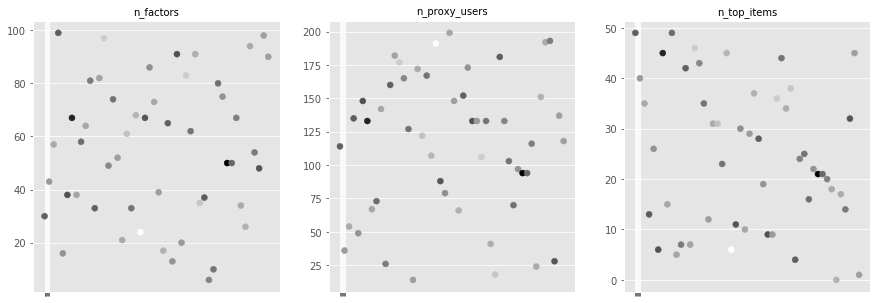

In [267]:
import hyperopt.plotting

plt.figure( figsize=(10,5))
hyperopt.plotting.main_plot_history(trials)
plt.figure( figsize=(10,5))
hyperopt.plotting.main_plot_histogram(trials)
plt.figure( figsize=(15,5))
hyperopt.plotting.main_plot_vars(trials)


## Plot performance of hyperparams across the range tested

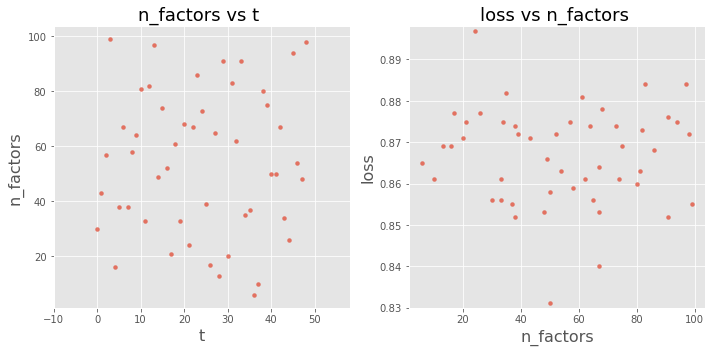

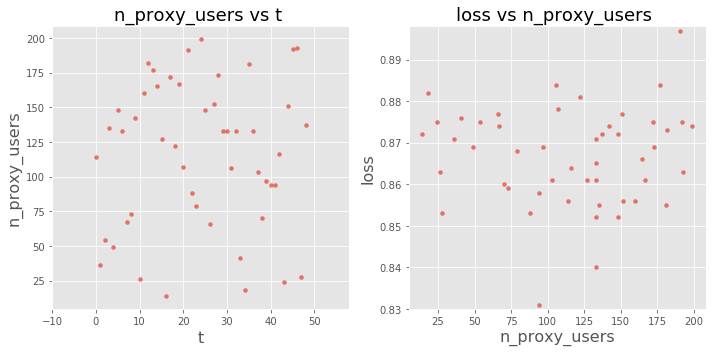

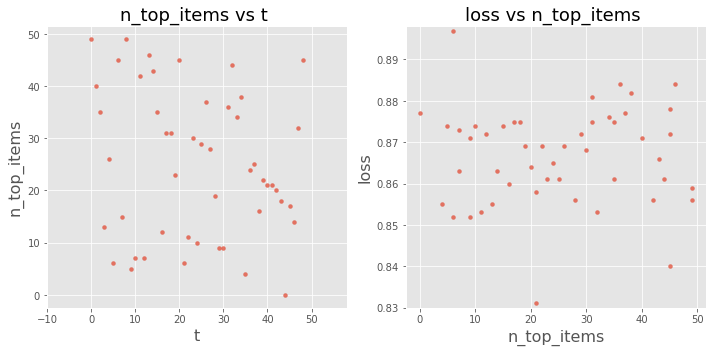

In [268]:

# only get x and y vals for plotting if there is an associated 
#  loss value. 
#  Additionally, need to deal with nested results 
def get_plot_vals(results, paramname):
    x_val = [t['tid'] for t in results]
    y_val = [t['misc']['vals'][paramname] for t in results]
    # list of lists means some entries are empty
    if type(y_val[0]) is list: 
        ytemp = np.array([y[0] if y else np.nan for y in y_val])
        y_val = np.array(ytemp)[~np.isnan(ytemp)]
        x_val = np.array(x_val)[~np.isnan(ytemp)]
    x_loss = [t['misc']['vals'][paramname] for t in results]
    y_loss = [t['result']['loss'] for t in results]
    # list of lists means some entries are empty
    if type(x_loss[0]) is list:
        xtemp = np.array([x[0] if x else np.nan for x in x_loss])
        y_loss = np.array(y_loss)[~np.isnan(xtemp)]
        x_loss = np.array(xtemp)[~np.isnan(xtemp)]
    return x_val, y_val, x_loss, y_loss

# if 'loss' not in results[-1]['result']:
#     results = results[:-1]

results = trials.trials[:-1]
# results = trials.trials
times = [t['tid'] for t in results]

for paramname in results[0]['misc']['vals'].keys():
    x_val, y_val, x_loss, y_loss = get_plot_vals(results, paramname)
    
    f, ax = plt.subplots(1,2, figsize=(10,5))
    xs = times
    # param value over time
    ax[0].set_xlim(xs[0]-10, xs[-1]+10)
    ax[0].scatter(x_val, y_val, s=20, linewidth=0.01, alpha=0.75)
    ax[0].set_title('%s vs t '%(paramname), fontsize=18)
    ax[0].set_xlabel('t', fontsize=16)
    ax[0].set_ylabel(paramname, fontsize=16)
    
    # loss vs param val
    ax[1].set_ylim(min(y_loss)-.001, max(y_loss)+.001)
    ax[1].scatter(x_loss, y_loss, s=20, linewidth=0.01, alpha=0.75)
    ax[1].set_title('loss vs %s '%(paramname), fontsize=18)
    ax[1].set_xlabel(paramname, fontsize=16)
    ax[1].set_ylabel('loss', fontsize=16)
    plt.tight_layout()
